In [1]:
# !git clone https://github.com/deepmind/dsprites-dataset.git

In [2]:
import tensorflow as tf 
tf.enable_eager_execution()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [4]:
## Code from Deepmind's Github
load_data = np.load("dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz", encoding='bytes')
imgs = load_data['imgs']
latents_values = load_data['latents_values']
latents_classes = load_data['latents_classes']
metadata = load_data['metadata'][()]

print('Metadata: \n', metadata)

Metadata: 
 {b'date': b'April 2017', b'description': b'Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6 disentangled latent factors.This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite. All possible variations of the latents are present. Ordering along dimension 1 is fixed and can be mapped back to the exact latent values that generated that image.We made sure that the pixel outputs are different. No noise added.', b'version': 1, b'latents_names': (b'color', b'shape', b'scale', b'orientation', b'posX', b'posY'), b'latents_possible_values': {b'orientation': array([0.        , 0.16110732, 0.32221463, 0.48332195, 0.64442926,
       0.80553658, 0.96664389, 1.12775121, 1.28885852, 1.44996584,
       1.61107316, 1.77218047, 1.93328779, 2.0943951 , 2.25550242,
       2.41660973, 2.57771705, 2.73882436, 2.89993168, 3.061039  ,
       3.22214631, 3.38325363, 3.54436094, 3.70546826, 3.86657557,
       4.02768289, 4.18879

In [5]:
latents_sizes = metadata[b'latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
    return np.dot(latents, latents_bases).astype(int)

def sample_latent(size=1):
    samples = np.zeros((size, latents_sizes.size))
    for lat_i, lat_size in enumerate(latents_sizes):
        samples[:, lat_i] = np.random.randint(lat_size, size=size)

    return samples

def show_images_grid(imgs_, num_images=25):
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()

    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')

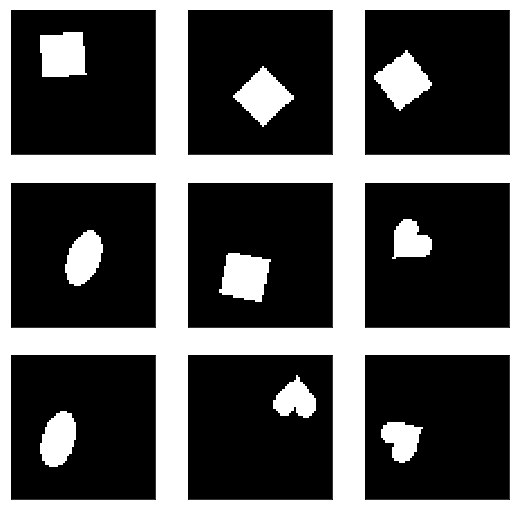

In [8]:
latents_sampled = sample_latent(size=60000)

latents_sampled[:, 2] = 5
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

show_images_grid(imgs_sampled, 9)

In [9]:
imgs_sampled = imgs_sampled.reshape(imgs_sampled.shape[0], 64, 64, 1).astype('float32')

In [10]:
TRAIN_BUF = 60000
BATCH_SIZE = 100

TEST_BUF = 10000

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(imgs_sampled).shuffle(TRAIN_BUF).batch(BATCH_SIZE)

In [12]:
class AutoEncoderSprite(tf.keras.Model):
    """Same Architecture"""
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(64, 64, 1)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=4, strides=(2, 2), activation=tf.nn.elu),
            tf.keras.layers.Conv2D(filters=32, kernel_size=4, strides=(2, 2), activation=tf.nn.elu),
            tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=(2, 2), activation=tf.nn.elu),
            tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=(2, 2), activation=tf.nn.elu),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim),
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=2*2*64, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(2, 2, 64)),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=(2, 2), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=(2, 2), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=4, strides=(4, 4), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=(2, 2), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=1, strides=(1, 1), padding="SAME"),
        ])
        
    def call(self, img):
        latent = self.encoder(img)
        out = self.decoder(latent)
        
        out = tf.nn.sigmoid(out)
        return latent, out

In [13]:
auto = AutoEncoderSprite(50)

In [14]:
optimizer = tf.train.AdamOptimizer(5e-5)

for e in range(4):
    print(f"At epoch {e}")
    for i, img in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            tape.watch(auto.variables)
            latent, out = auto(img)

            loss = tf.losses.mean_squared_error(img, out)
            
            if i % 100 == 0:
                print(loss)

        grad = tape.gradient(loss, auto.variables)
        optimizer.apply_gradients(zip(grad, auto.variables))
    print(f"---------")

At epoch 0
tf.Tensor(0.25000066, shape=(), dtype=float32)
tf.Tensor(0.08352737, shape=(), dtype=float32)
tf.Tensor(0.068492614, shape=(), dtype=float32)
tf.Tensor(0.06836165, shape=(), dtype=float32)
tf.Tensor(0.045711726, shape=(), dtype=float32)
tf.Tensor(0.026389642, shape=(), dtype=float32)
---------
At epoch 1
tf.Tensor(0.01850652, shape=(), dtype=float32)
tf.Tensor(0.015789904, shape=(), dtype=float32)
tf.Tensor(0.014331057, shape=(), dtype=float32)
tf.Tensor(0.013594167, shape=(), dtype=float32)
tf.Tensor(0.013495383, shape=(), dtype=float32)
tf.Tensor(0.013677079, shape=(), dtype=float32)
---------
At epoch 2
tf.Tensor(0.0132732, shape=(), dtype=float32)
tf.Tensor(0.013153209, shape=(), dtype=float32)
tf.Tensor(0.0128712235, shape=(), dtype=float32)
tf.Tensor(0.012944568, shape=(), dtype=float32)
tf.Tensor(0.012764361, shape=(), dtype=float32)
tf.Tensor(0.012737829, shape=(), dtype=float32)
---------
At epoch 3
tf.Tensor(0.012687106, shape=(), dtype=float32)
tf.Tensor(0.0123098

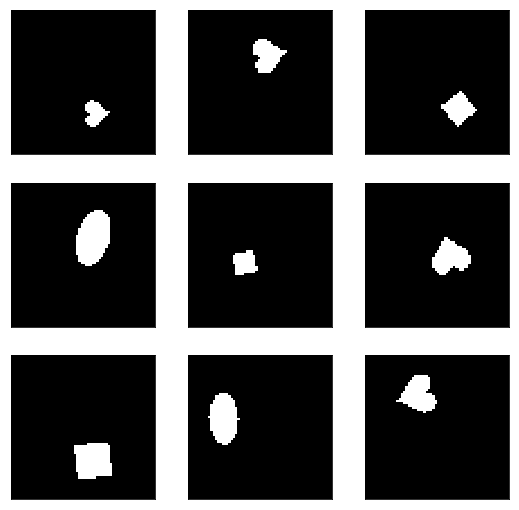

In [15]:
latents_sampled = sample_latent(size=9)
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

show_images_grid(imgs_sampled, 9)
test_images = imgs_sampled.reshape(imgs_sampled.shape[0], 64, 64, 1).astype('float32')

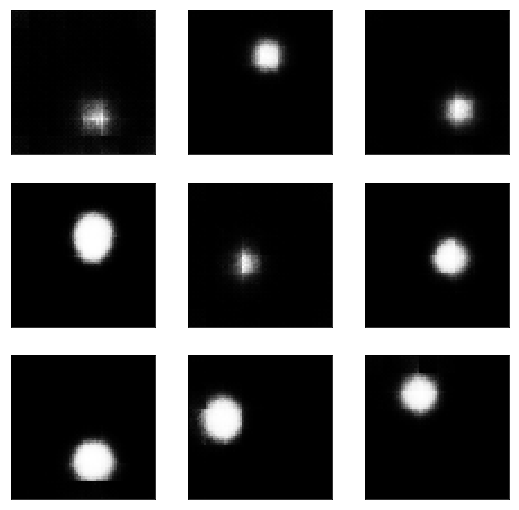

In [16]:
out = auto(tf.convert_to_tensor(test_images))[1]
out = tf.squeeze(out)
show_images_grid(out.numpy(), 9)